In [1]:
import os
import shutil
import random
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from matplotlib.image import imread
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from google.colab import drive
import zipfile
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.utils import plot_model
from tensorflow.keras.applications import EfficientNetV2S
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Ekstrak file dataset.zip
zip_path = "/content/drive/MyDrive/vegecare_dataset.zip"
extract_path = "/content/"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("Extracted to:", extract_path)

Extracted to: /content/


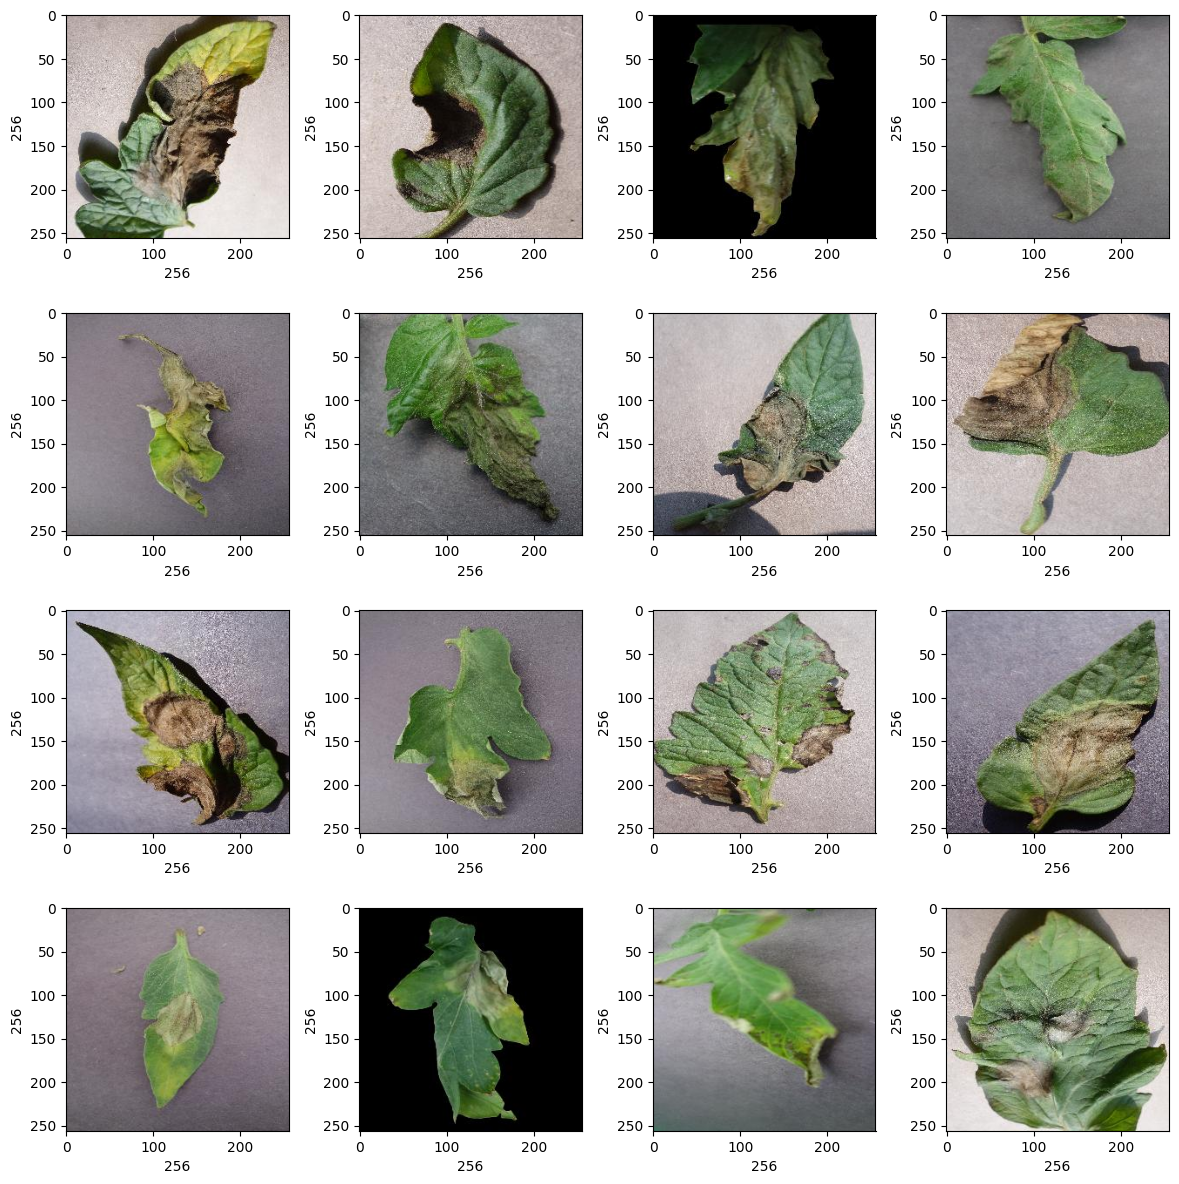

In [4]:
plt.figure(figsize = (12, 12))
dataset_path = "/content/dataset_update_augment/Tomato__Late_Blight"

for i in range(1, 17):
    plt.subplot(4, 4, i)
    plt.tight_layout()
    rand_img = imread(dataset_path +'/'+ random.choice(sorted(os.listdir(dataset_path))))
    plt.imshow(rand_img)
    plt.xlabel(rand_img.shape[1], fontsize = 10)
    plt.ylabel(rand_img.shape[0], fontsize = 10)

In [5]:
# Paths
original_dataset_dir = "/content/dataset_update_augment"
output_dir = "/content/splitted_dataset"

# Split ratios
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

# Create directories for train, val, and test
for split in ["train", "val", "test"]:
    os.makedirs(os.path.join(output_dir, split), exist_ok=True)

# Process each class
for class_name in os.listdir(original_dataset_dir):
    class_dir = os.path.join(original_dataset_dir, class_name)
    if not os.path.isdir(class_dir):
        continue

    # Get all files in the class directory
    files = os.listdir(class_dir)
    random.shuffle(files)

    # Compute split sizes
    total_files = len(files)
    train_size = int(total_files * train_ratio)
    val_size = int(total_files * val_ratio)

    # Split files
    train_files = files[:train_size]
    val_files = files[train_size:train_size + val_size]
    test_files = files[train_size + val_size:]

    # Copy files to the respective directories
    for split, split_files in zip(["train", "val", "test"], [train_files, val_files, test_files]):
        split_dir = os.path.join(output_dir, split, class_name)
        os.makedirs(split_dir, exist_ok=True)
        for file in split_files:
            src_file = os.path.join(class_dir, file)
            dest_file = os.path.join(split_dir, file)
            shutil.copy(src_file, dest_file)

print("Dataset split completed!")


Dataset split completed!


In [10]:
def analyze_class_distribution(directory):
    """
    Analyze and visualize class distribution in the dataset
    """
    class_counts = {}
    for class_name in os.listdir(directory):
        class_path = os.path.join(directory, class_name)
        if os.path.isdir(class_path):
            class_counts[class_name] = len(os.listdir(class_path))

    # Visualize class distribution
    plt.figure(figsize=(15, 6))
    plt.bar(class_counts.keys(), class_counts.values())
    plt.title('Class Distribution')
    plt.xlabel('Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    return class_counts

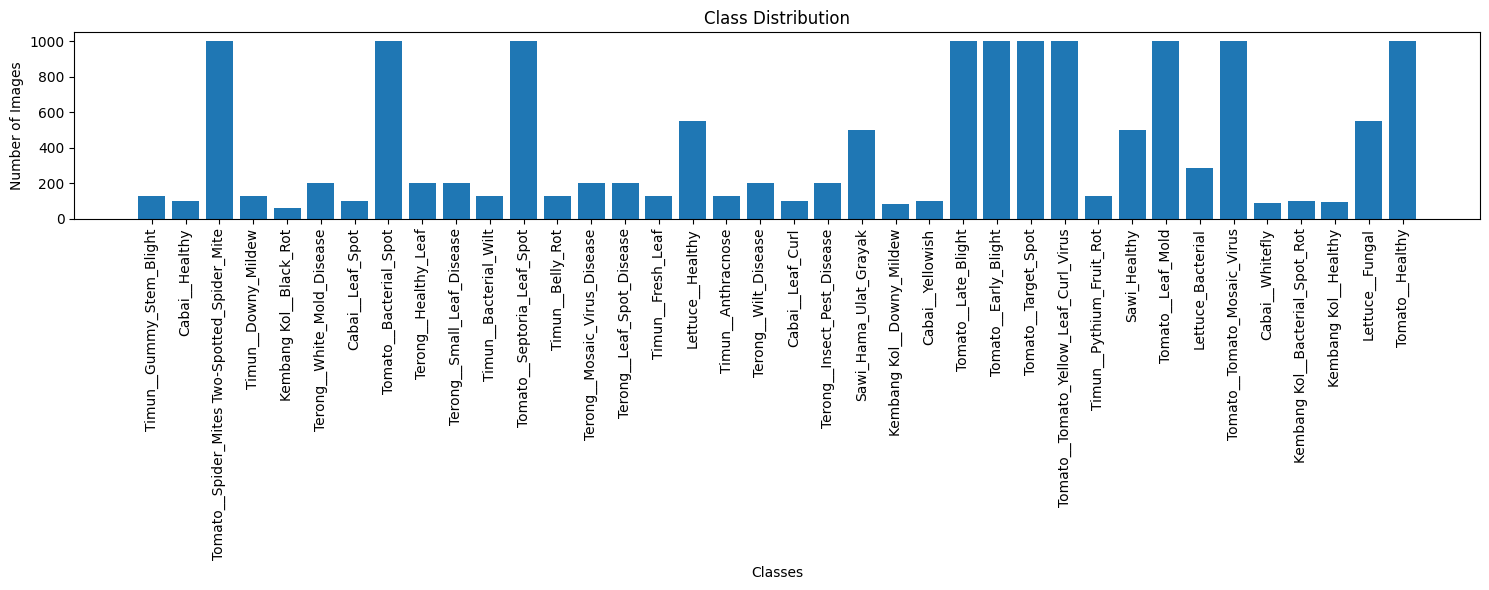

In [11]:
class_distribution = analyze_class_distribution(original_dataset_dir)

In [8]:
classes = ['Cabai__Healthy', 'Cabai__Leaf_Curl', 'Cabai__Leaf_Spot', 'Cabai__Whitefly', 'Cabai__Yellowish', 'Kembang Kol__Bacterial_Spot_Rot', 'Kembang Kol__Black_Rot', 'Kembang Kol__Downy_Mildew', 'Kembang Kol__Healthy', 'Lettuce_Bacterial', 'Lettuce__Fungal', 'Lettuce__Healthy', 'Sawi_Hama_Ulat_Grayak', 'Sawi_Healthy', 'Terong__Healthy_Leaf', 'Terong__Insect_Pest_Disease', 'Terong__Leaf_Spot_Disease', 'Terong__Mosaic_Virus_Disease', 'Terong__Small_Leaf_Disease', 'Terong__White_Mold_Disease', 'Terong__Wilt_Disease', 'Timun__Anthracnose', 'Timun__Bacterial_Wilt', 'Timun__Belly_Rot', 'Timun__Downy_Mildew', 'Timun__Fresh_Leaf', 'Timun__Gummy_Stem_Blight', 'Timun__Pythium_Fruit_Rot', 'Tomato__Bacterial_Spot', 'Tomato__Early_Blight', 'Tomato__Healthy', 'Tomato__Late_Blight', 'Tomato__Leaf_Mold', 'Tomato__Septoria_Leaf_Spot', 'Tomato__Spider_Mites Two-Spotted_Spider_Mite', 'Tomato__Target_Spot', 'Tomato__Tomato_Mosaic_Virus', 'Tomato__Tomato_Yellow_Leaf_Curl_Virus']

In [12]:
train_dir = os.path.join(output_dir, "train")

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Hitung jumlah data per kelas
class_counts = {}
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if os.path.isdir(class_path):
        class_counts[class_name] = len(os.listdir(class_path))

# Temukan kelas dengan data terbanyak
max_count = max(class_counts.values())

# Oversampling
for class_name, count in class_counts.items():
    if count < max_count:
        class_path = os.path.join(train_dir, class_name)
        files = os.listdir(class_path)
        file_paths = [os.path.join(class_path, file) for file in files]

        # Tambahkan data hingga mencapai max_count
        while len(os.listdir(class_path)) < max_count:
            for file_path in file_paths:
                # Membaca gambar
                image = Image.open(file_path)
                if image.mode == 'RGBA':
                    image = image.convert('RGB')
                image_array = np.array(image)

                # Augmentasi gambar
                image_augmented = next(datagen.flow(
                    np.expand_dims(image_array, axis=0),
                    batch_size=1
                ))[0].astype(np.uint8)

                # Simpan gambar augmentasi
                new_file_name = f"aug_{len(os.listdir(class_path))}.jpg"
                new_file_path = os.path.join(class_path, new_file_name)
                Image.fromarray(image_augmented).save(new_file_path)

                # Hentikan jika sudah mencapai max_count
                if len(os.listdir(class_path)) >= max_count:
                    break

print("Oversampling completed!")

Oversampling completed!


In [ ]:
# data_augmentation = tf.keras.Sequential([
#     tf.keras.layers.RandomFlip("horizontal_and_vertical"),
#     tf.keras.layers.RandomRotation(0.2),
#     tf.keras.layers.RandomZoom(0.2),
#     tf.keras.layers.RandomContrast(0.2),
#     tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
# ])

In [23]:
def create_datasets(path_dataset, image_size=(299, 299), batch_size=20):
    AUTOTUNE = tf.data.AUTOTUNE
    normalization_layer = tf.keras.layers.Rescaling(1./255)

    train_ds = tf.keras.utils.image_dataset_from_directory(
        '/content/splitted_dataset/train',
        seed=0,
        batch_size=batch_size,
        label_mode='categorical',
        image_size=image_size,
    ).map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    validation_ds = tf.keras.utils.image_dataset_from_directory(
        '/content/splitted_dataset/val',
        seed=0,
        batch_size=batch_size,
        label_mode='categorical',
        image_size=image_size,
    ).map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    test_ds = tf.keras.utils.image_dataset_from_directory(
        '/content/splitted_dataset/test',
        seed=0,
        batch_size=batch_size,
        label_mode='categorical',
        image_size=image_size,
    ).map(lambda x, y: (normalization_layer(x), y)).prefetch(buffer_size=AUTOTUNE)

    return train_ds, validation_ds, test_ds

train_ds, validation_ds, test_ds = create_datasets('/content/splitted_dataset')

Found 30400 files belonging to 38 classes.
Found 1543 files belonging to 38 classes.
Found 1562 files belonging to 38 classes.


In [24]:
IMG_SHAPE = (299, 299, 3)
base_model = keras.applications.InceptionV3(
    input_shape=IMG_SHAPE,
    include_top=False,
    weights="imagenet",

)
base_model.trainable = False

# tuning_layer_name = 'block14_sepconv2'
# tuning_layer = base_model.get_layer(tuning_layer_name)
# tuning_index = base_model.layers.index(tuning_layer)

# for layer in base_model.layers[:tuning_index]:
#     layer.trainable = False

In [25]:
model = Sequential([
    base_model,
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.5),
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(len(classes), activation='softmax')
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ inception_v3 (Functional)            │ (None, 8, 8, 2048)          │      21,802,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_283 (Conv2D)                  │ (None, 6, 6, 256)           │       4,718,848 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_13 (MaxPooling2D)      │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 3, 3, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 2304)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 38)                  │           9,766 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 27,121,478 (103.46 MB)

 Trainable params: 5,318,694 (20.29 MB)

 Non-trainable params: 21,802,784 (83.17 MB)

In [26]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001, weight_decay=1e-5)

model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizer,
    metrics=['accuracy']
)

In [27]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
    )
file_path = "/content/vegecare_model_efficientnetv3s.weights.h5"

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=file_path,
    save_weights_only=True,
    monitor='val_accuracy',
    save_best_only=True,
    mode='max'
    )

In [28]:
def calculate_class_weights(train_dataset):
    labels = []
    for _, y in train_dataset:
        labels.extend(np.argmax(y.numpy(), axis=1))

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(labels),
        y=labels
    )
    return dict(enumerate(class_weights))

class_weights = calculate_class_weights(train_ds)

In [29]:
epochs = 50
batch_size = 32

# Update model training
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=validation_ds,
    batch_size=batch_size,
    class_weight=class_weights  # Add class weights
)

Epoch 1/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 213s 125ms/step - accuracy: 0.2574 - loss: 2.7566 - val_accuracy: 0.7213 - val_loss: 0.8667
Epoch 2/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 234s 117ms/step - accuracy: 0.6471 - loss: 1.0918 - val_accuracy: 0.7868 - val_loss: 0.6452
Epoch 3/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 176s 116ms/step - accuracy: 0.7572 - loss: 0.7461 - val_accuracy: 0.8069 - val_loss: 0.5731
Epoch 4/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 207s 119ms/step - accuracy: 0.8154 - loss: 0.5674 - val_accuracy: 0.8561 - val_loss: 0.4632
Epoch 5/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 204s 120ms/step - accuracy: 0.8554 - loss: 0.4392 - val_accuracy: 0.8367 - val_loss: 0.4970
Epoch 6/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 198s 118ms/step - accuracy: 0.8782 - loss: 0.3690 - val_accuracy: 0.8483 - val_loss: 0.4925
Epoch 7/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 203s 118ms/step - accuracy: 0.8940 - loss: 0.3214 - val_accuracy: 0.8568 - val_loss: 0.4896
Epoch 8/50
1520/1520 ━━━━━━━━━━━━━━━━━━━━ 207s 122ms/step - ac

KeyboardInterrupt: 

In [30]:
MODEL_PATH = "/content/vegecare_model_inceptionv3.h5"
model.save(MODEL_PATH)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━

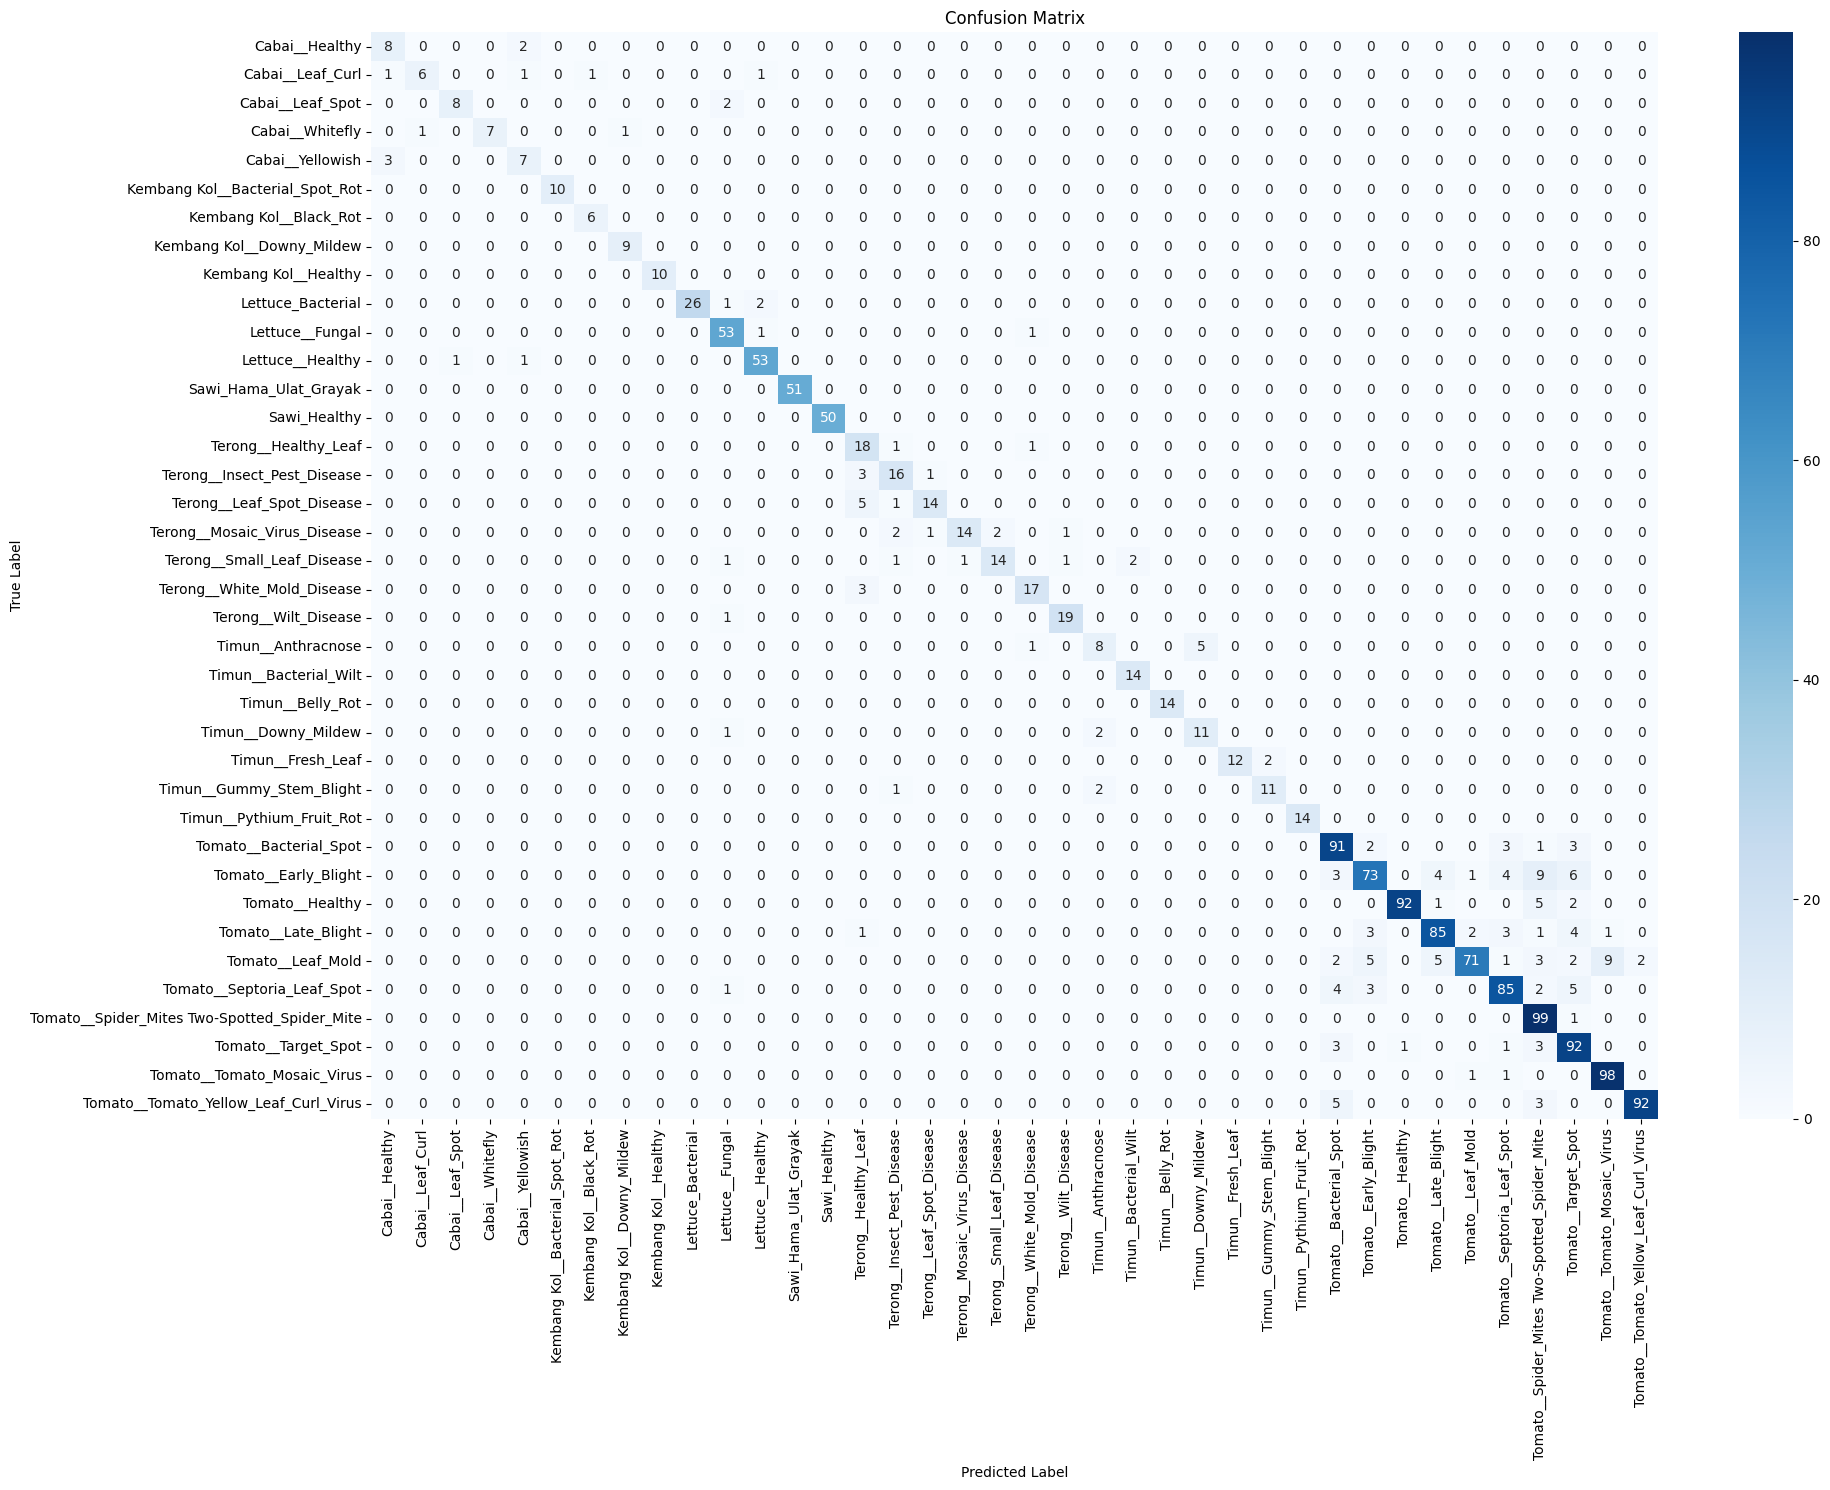


Per-Class Accuracy:
Cabai__Healthy:
  Total Samples: 10
  Correct Predictions: 8
  Accuracy: 80.00%
Cabai__Leaf_Curl:
  Total Samples: 10
  Correct Predictions: 6
  Accuracy: 60.00%
Cabai__Leaf_Spot:
  Total Samples: 10
  Correct Predictions: 8
  Accuracy: 80.00%
Cabai__Whitefly:
  Total Samples: 9
  Correct Predictions: 7
  Accuracy: 77.78%
Cabai__Yellowish:
  Total Samples: 10
  Correct Predictions: 7
  Accuracy: 70.00%
Kembang Kol__Bacterial_Spot_Rot:
  Total Samples: 10
  Correct Predictions: 10
  Accuracy: 100.00%
Kembang Kol__Black_Rot:
  Total Samples: 6
  Correct Predictions: 6
  Accuracy: 100.00%
Kembang Kol__Downy_Mildew:
  Total Samples: 9
  Correct Predictions: 9
  Accuracy: 100.00%
Kembang Kol__Healthy:
  Total Samples: 10
  Correct Predictions: 10
  Accuracy: 100.00%
Lettuce_Bacterial:
  Total Samples: 29
  Correct Predictions: 26
  Accuracy: 89.66%
Lettuce__Fungal:
  Total Samples: 55
  Correct Predictions: 53
  Accuracy: 96.36%
Lettuce__Healthy:
  Total Samples: 55
  C

In [31]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix

def evaluate_model_performance(model, test_ds, classes):
    # Collect true labels and predictions
    true_labels = []
    predictions = []

    # Iterate through test dataset to get true labels and predictions
    for images, labels in test_ds:
        # Get class indices from one-hot encoded labels
        true_batch_labels = np.argmax(labels.numpy(), axis=1)
        true_labels.extend(true_batch_labels)

        # Get model predictions
        batch_predictions = model.predict(images)
        predictions.extend(np.argmax(batch_predictions, axis=1))

    # Convert to numpy arrays
    true_labels = np.array(true_labels)
    predictions = np.array(predictions)

    # 1. Detailed Classification Report
    print("Detailed Classification Report:")
    print(classification_report(true_labels, predictions, target_names=classes))

    # 2. Confusion Matrix Visualization
    plt.figure(figsize=(20,15))
    cm = confusion_matrix(true_labels, predictions)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes,
                yticklabels=classes)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.show()

    # 3. Per-class Accuracy
    per_class_accuracy = {}
    for i, class_name in enumerate(classes):
        class_total = np.sum(true_labels == i)
        class_correct = np.sum((true_labels == i) & (predictions == i))
        accuracy = class_correct / class_total if class_total > 0 else 0
        per_class_accuracy[class_name] = {
            'total_samples': class_total,
            'correct_predictions': class_correct,
            'accuracy': accuracy
        }

    # Print Per-class Accuracy
    print("\nPer-Class Accuracy:")
    for class_name, stats in per_class_accuracy.items():
        print(f"{class_name}:")
        print(f"  Total Samples: {stats['total_samples']}")
        print(f"  Correct Predictions: {stats['correct_predictions']}")
        print(f"  Accuracy: {stats['accuracy']:.2%}")

    return true_labels, predictions, per_class_accuracy

# Use the function after training
true_labels, predictions, per_class_accuracy = evaluate_model_performance(model, test_ds, classes)

In [37]:
def plot_learning_curves(history):
    plt.figure(figsize=(12,4))

    # Accuracy
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Call after training
plot_learning_curves(history)

NameError: name 'history' is not defined

In [34]:
from sklearn.metrics import f1_score, precision_recall_fscore_support

def calculate_advanced_metrics(true_labels, predictions):
    # Macro average (treats all classes equally)
    macro_precision, macro_recall, macro_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='macro'
    )

    # Weighted average (considers class imbalance)
    weighted_precision, weighted_recall, weighted_f1, _ = precision_recall_fscore_support(
        true_labels, predictions, average='weighted'
    )

    print("\nAdvanced Metrics:")
    print(f"Macro F1 Score: {macro_f1:.4f}")
    print(f"Weighted F1 Score: {weighted_f1:.4f}")
    print(f"Macro Precision: {macro_precision:.4f}")
    print(f"Macro Recall: {macro_recall:.4f}")
    print(f"Weighted Precision: {weighted_precision:.4f}")
    print(f"Weighted Recall: {weighted_recall:.4f}")

# Calculate after getting predictions
calculate_advanced_metrics(true_labels, predictions)


Advanced Metrics:
Macro F1 Score: 0.8661
Weighted F1 Score: 0.8815
Macro Precision: 0.8769
Macro Recall: 0.8653
Weighted Precision: 0.8892
Weighted Recall: 0.8822
